In [1]:
import cv2
import sklearn
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn.decomposition import PCA
from copy import deepcopy
from scipy import ndimage

from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
#Comment this pre submission
%matplotlib inline

In [2]:
def calculate_ma(arr):
#     arr = np.delete(arr, 0)
#     arr = np.append(arr, vertical[j])
    ave = 0.0
    for i in range(len(arr)):
        if arr[i] == -1:
            continue
        ave += arr[i]
        
    ave = ave / float(len(arr))
#     print(arr)
#     print(ave)
    return ave

In [3]:
def get_best_shift(img):
    cy,cx = ndimage.measurements.center_of_mass(img)

    rows,cols = img.shape
    shiftx = np.round(cols/2.0-cx).astype(int)
    shifty = np.round(rows/2.0-cy).astype(int)

    return shiftx,shifty

In [4]:
def shift(img,sx,sy):
    rows,cols = img.shape
    M = np.float32([[1,0,sx],[0,1,sy]])
    shifted = cv2.warpAffine(img,M,(cols,rows))
    return shifted  

In [5]:
## ADABOOST
def boost(X, y, w):
    est = deepcopy(clf)
    est.fit(X, y, sample_weight=w)
    
    y_pred = est.predict(X)
    incorrect = y_pred != y
    
    estimator_error = np.dot(incorrect, w) / np.sum(w, axis=0)
    
    if estimator_error >= 1 - 1 / n_classes:
            return None, None, None
    
    print("First pass, error:  ", estimator_error)
    
    estimator_weight = learning_rate * np.log(min((1 - estimator_error) / estimator_error, 999999)) + np.log(
            n_classes - 1)
    
    if estimator_weight <= 0:
            return None, None, None
        
    print ("Second pass, weight: ", estimator_weight)
        
    w *= np.exp(estimator_weight * incorrect)

    sample_weight_sum = np.sum(w, axis=0)
    
    if sample_weight_sum <= 0:
        return None, None, None
    
    print("Third pass")

    # normalize sample weight
    w /= sample_weight_sum

    # append the estimator
    estimators.append(est)

    print("Fourth pass")
    return w, estimator_weight, estimator_error
    

In [6]:
def predict(X):
    classes_ = classes[:, np.newaxis]
    pred = None
    
    pred = sum((e_.predict(X) == classes_).T * w_
               for e_, w_ in zip(estimators, estimator_weights))
    pred /= estimator_weights.sum()
    
    if n_classes == 2:
        pred[:, 0] *= -1
        pred = pred.sum(axis=1)
        return classes.take(pred > 0, axis=0)

    return classes.take(np.argmax(pred, axis=1), axis=0)

In [7]:
def segment(img, img_name):
    # Clean the image
    img_dil = cv2.dilate(img, np.ones((7,7), np.uint8))
    img_blur = cv2.medianBlur(img_dil, 21)
    img_diff = 255 - cv2.absdiff(img, img_blur)
    img_norm = img_diff.copy()
    cv2.normalize(img_diff, img_norm, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
    _, img_thr = cv2.threshold(img_norm, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    img_final = 255 - img_thr
    # _, img_thr = cv2.threshold(img_norm, 230, 0, cv2.THRESH_TRUNC)
    # cv2.normalize(img_thr, img_thr, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
    # img_final = 255 - img_thr

    #Image 1
    if (img_name == '1.jpg'):
        img_final = cv2.dilate(img_final, np.ones((2,2), np.uint8))

    #Image 2
    elif (img_name == '2.bmp'):
        img_final = cv2.dilate(img_final, np.ones((7,7), np.uint8))

    #Image 3
    elif (img_name == '3.bmp'):
        img_final = cv2.erode(img_final, np.ones((2,2), np.uint8))
        img_final = cv2.dilate(img_final, np.ones((7,7), np.uint8))

    else:
        img_final = cv2.dilate(img_final, np.ones((3,3), np.uint8))

    # plt.imshow(img_final, 'gray')
    # plt.show()

    # Get horizontal peaks
    horizontal = np.sum(img_final, axis=1)
    horizontal_peaks = []
    horizontal_peak_start = -1

    prev_ave = -1
    curr_ave = -1

    ma_hor = np.full(5, -1)
    hor_min = np.amin(horizontal)
    hor_max = np.amax(horizontal)
    threshold = (hor_max - hor_min) * 0.02

    for i in range(horizontal.size):

        ma_hor = np.delete(ma_hor, 0)
        ma_hor = np.append(ma_hor, horizontal[i])
        prev_ave = curr_ave
        curr_ave = calculate_ma(ma_hor)

        if curr_ave - prev_ave > threshold and horizontal_peak_start == -1:
            horizontal_peak_start = i
        elif horizontal[i] < 300 and horizontal_peak_start != -1:
            horizontal_peaks.append({'start': horizontal_peak_start, 'end': i})
            horizontal_peak_start = -1

    # To plot horizontal histograms

    # plt.plot(horizontal)
    # plt.show()

    # To plot the horizontal slices

    # for i in range(len(horizontal_peaks)):
    #     hor_slice = img_final[horizontal_peaks[i]['start']: horizontal_peaks[i]['end']]
    #     plt.subplot(len(horizontal_peaks), 1, i+1)
    #     plt.imshow(hor_slice, 'gray')
    # plt.show()

    # Get vertical peaks for each horizontal peaks

    digits_bounds = []

    for i in range(len(horizontal_peaks)):
        vertical = np.sum(img_final[horizontal_peaks[i]['start']: horizontal_peaks[i]['end']], axis = 0)
#         plt.subplot(len(horizontal_peaks), 1, i+1)
#         plt.plot(vertical)

        prev_ave = -1
        curr_ave = -1

        vertical_peak_start = -1
        ma_vert = np.full(5, -1)
        vert_min = np.amin(vertical)
        vert_max = np.amax(vertical)
        threshold = (vert_max - vert_min) * 0.015

        for j in range(vertical.size):

            ma_vert = np.delete(ma_vert, 0)
            ma_vert = np.append(ma_vert, vertical[j])
            prev_ave = curr_ave
            curr_ave = calculate_ma(ma_vert)

    #         calculate_ma(ma_vert, vertical[j])
            if curr_ave - prev_ave > threshold and vertical_peak_start == -1:
                vertical_peak_start = j
            elif vertical[j] < (vert_max - vert_min) * 0.05 and vertical_peak_start != -1:

                digits_bounds.append({ \
                    'y_start':horizontal_peaks[i]['start'], \
                    'y_end': horizontal_peaks[i]['end'], \
                    'x_start': vertical_peak_start, \
                    'x_end' : j})
                vertical_peak_start = -1
#     plt.show()

    digits_seg = []

    for i in range(len(digits_bounds)):
        digit = img_final[digits_bounds[i]['y_start']: digits_bounds[i]['y_end'], digits_bounds[i]['x_start'] : digits_bounds[i]['x_end']]
#         plt.subplot(2, int((len(digits_bounds) / 2)) + 1, i+1)
#         plt.imshow(digit, 'gray')
        digits_seg.append(digit)
#     plt.show()
    
#     print(digits_seg)

    padded_imgs = []

    for i in range(len(digits_seg)):
        dig = digits_seg[i]

        while np.sum(dig[0]) == 0:
            dig = dig[1:]

        while np.sum(dig[:,0]) == 0:
            dig = np.delete(dig,0,1)

        while np.sum(dig[-1]) == 0:
            dig = dig[:-1]

        while np.sum(dig[:,-1]) == 0:
            dig = np.delete(dig,-1,1)

        rows,cols = dig.shape
    #     print(dig.shape)

        if (rows > cols):
            factor = 20.0/rows
            rows = 20
            cols = int(round(cols*factor))
            dig = cv2.resize(dig, (cols,rows))
        else:
            factor = 20.0/cols
            cols = 20
            rows = int(round(rows*factor))
            dig = cv2.resize(dig, (cols, rows))

        colsPadding = (int(math.ceil((28-cols)/2.0)),int(math.floor((28-cols)/2.0)))
        rowsPadding = (int(math.ceil((28-rows)/2.0)),int(math.floor((28-rows)/2.0)))
        dig = np.lib.pad(dig,(rowsPadding,colsPadding),'constant')

        shiftx,shifty = get_best_shift(dig)
        shifted = shift(dig,shiftx,shifty)
        res_img = shifted

        padded_imgs.append(res_img)
#         res_img = res_img/255.0*2 - 1
#         res_test = np.array(res_img)
#         res_test = res_test.ravel()
#         converted_for_classifier.append(res_test)

    #     print (dig_shape)
    #     top_pad = 0
    #     bottom_pad = 0
    #     left_pad = 0
    #     right_pad = 0
    #     if (dig.shape[0] > dig.shape[1]):
    #         left_pad = math.floor((dig_shape[0] - dig_shape[1]) / 2)
    #         right_pad = math.ceil((dig_shape[0] - dig_shape[1]) / 2)
    #     elif (dig.shape[0] < dig.shape[1]):
    #         top_pad = math.floor((dig_shape[1] - dig_shape[0]) / 2)
    #         bottom_pad = math.ceil((dig_shape[1] - dig_shape[0]) / 2)

    # #     print (left_pad, right_pad, top_pad, bottom_pad)
    #     res_img = cv2.copyMakeBorder(dig, top_pad, bottom_pad, left_pad, right_pad, cv2.BORDER_CONSTANT, 0)
    #     res_img = cv2.resize(res_img, (28, 28))
    # #     res_img = cv2.dilate(res_img, np.ones((2,2), np.uint8))
    #     res_img = res_img/255.0*2 - 1
    #     padded_imgs.append(res_img)
    #     res_test = np.array(res_img)
    #     res_test = res_test.ravel()
    #     converted_for_classifier.append(res_test)

    for i in range(len(padded_imgs)):
        plt.subplot(2, math.ceil(len(digits_seg) / 2), i+1)
        plt.imshow(padded_imgs[i], 'gray')
    plt.show()


    return padded_imgs[:]

    # vertical = np.sum(img_final, axis = 0)
    # plt.plot(vertical)
    # plt.show()

    # cv2.imshow('image',img)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()

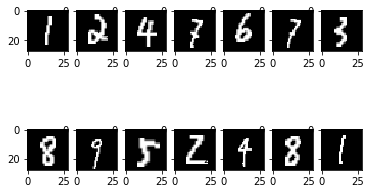

In [23]:
# Load the image
img_name = '1.jpg'
img = cv2.imread(img_name, 0)
digits_seg = segment(img, img_name)

converted_for_classifier = []

for i in range(len(digits_seg)):
    ith_im = digits_seg[i]
    cv2.imwrite("" + str(i) + ".jpg", digits_seg[i])
    ith_im = ith_im / 255.0 * 2 - 1
    ith_im = ith_im.ravel()
    converted_for_classifier.append(ith_im)

# res_img = res_img/255.0*2 - 1
# res_test = np.array(res_img)
# res_test = res_test.ravel()
# converted_for_classifier.append(res_test)

In [9]:
mnist = fetch_mldata('MNIST original')

/usr/local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function fetch_mldata is deprecated; fetch_mldata was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function mldata_filename is deprecated; mldata_filename was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)


In [10]:
x_data = mnist.data
y_data = mnist.target
x_data = x_data/255.0*2 - 1

# pca = PCA(n_components = 25)
#40
# x_data = pca.fit_transform(x_data)

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data,
                                                        test_size=0.2,
                                                        random_state=42)

In [11]:
dtree = DecisionTreeClassifier(min_samples_split=4, min_samples_leaf=4)
# dtree = MLPClassifier(hidden_layer_sizes = (800,))

In [12]:
# cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
# parameters = {'min_impurity_decrease': (np.arange(0.0, 1.01, 0.1))}
# parameters = {'min_samples_split': (np.arange(2, 10, 1))}
# parameters = {'min_samples_leaf': (np.arange(1, 11))}
# parameters = {'max_features': (np.arange(10, 300, 10))}
# parameters = {'hidden_layer_sizes' : ((100,), (200,), (300,), (400,), (500,), (600,),(700,),(800,),(900,))}
# dtGS = GridSearchCV(dtree, parameters, cv = cv, scoring='accuracy', verbose=10, n_jobs=-1)
# dtGS.fit(x_train, y_train)

# print(dtGS.best_score_)
# print(dtGS.best_estimator_.hidden_layer_sizes)
# print(dtGS.cv_results_['mean_test_score'])
# print(dtGS.cv_results_['mean_train_score'])

In [13]:
clf = dtree
n_samples = x_train.shape[0]
classes = np.array(sorted(list(set(y_train))))
n_classes = len(classes)
w = np.ones(n_samples) / n_samples

#D-Tree good to 75, up to 100?
n_estimators = 75
learning_rate = 1

estimator_weights = np.zeros(n_estimators)
estimator_errors = np.ones(n_estimators)
estimators = list()

for i in range(n_estimators):
    print("Classifier " + str(i))
    w, estimator_weight, estimator_error = boost(x_train, y_train, w)
    
    if estimator_error == None:
        break
        
    estimator_errors[i] = estimator_error
    estimator_weights[i] = estimator_weight
        
    if estimator_error <= 0:
        break

Classifier 0
First pass, error:   0.045071428571428485
Second pass, weight:  5.2506125877781304
Third pass
Fourth pass
Classifier 1
First pass, error:   0.00952850688591851
Second pass, weight:  6.841117632510345
Third pass
Fourth pass
Classifier 2
First pass, error:   0.005676650014488645
Second pass, weight:  7.362925760330727
Third pass
Fourth pass
Classifier 3
First pass, error:   0.0036490540385909443
Second pass, weight:  7.806856161745811
Third pass
Fourth pass
Classifier 4
First pass, error:   0.001221407847559418
Second pass, weight:  8.903753535105297
Third pass
Fourth pass
Classifier 5
First pass, error:   0.0003711950466417506
Second pass, weight:  10.095636214697224
Third pass
Fourth pass
Classifier 6
First pass, error:   0.00033344908431523723
Second pass, weight:  10.202911447628283
Third pass
Fourth pass
Classifier 7
First pass, error:   0.0005379775753496319
Second pass, weight:  9.72438013517646
Third pass
Fourth pass
Classifier 8
First pass, error:   0.00021008293201

First pass, error:   7.71113606776741e-06
Second pass, weight:  13.970061897509407
Third pass
Fourth pass
Classifier 69
First pass, error:   0.00010534962773503844
Second pass, weight:  11.355345173481055
Third pass
Fourth pass
Classifier 70
First pass, error:   2.0668673212891455e-05
Second pass, weight:  12.98409528380336
Third pass
Fourth pass
Classifier 71
First pass, error:   9.285716729322066e-06
Second pass, weight:  13.784248465542602
Third pass
Fourth pass
Classifier 72
First pass, error:   1.9531924412821735e-05
Second pass, weight:  13.040665326908327
Third pass
Fourth pass
Classifier 73
First pass, error:   6.373440869960048e-06
Second pass, weight:  14.160589270124833
Third pass
Fourth pass
Classifier 74
First pass, error:   1.0772594413416662e-05
Second pass, weight:  13.635719007879079
Third pass
Fourth pass


In [17]:
# self_pred = predict(x_test)
# pred_acc = accuracy_score(y_test, self_pred)
# print (pred_acc)

0.971


In [20]:
convert_to_np = np.array(converted_for_classifier)
# pca_results = pca.transform(convert_to_np)

prediction_of_seg = predict(convert_to_np)
print(prediction_of_seg)
# prediction_of_seg = predict(pca_results)

[2. 0. 1. 1. 1. 0. 4. 2. 2. 1. 7. 1. 1. 0. 1.]
